# Importações

In [98]:
# Importaçòes
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
import plotly.graph_objects as gp
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score, RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import calibration_curve
import pickle

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
# Remover alertas
from sklearn.exceptions import DataConversionWarning
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Carregar dados

Os registros podem estar divididos em mais de um arquivo `.CSV` devido a grande quantidade de dados. Assim, todos os arquivos `.CSV` contidos no diretório `./dados` serão carregados em um único dataframe.   
Nesse estudo a variável dependente será a `nova_terapia` e as demais serão utilizadas para predição.

In [11]:
# Listar os arquivos do tipo '.CSV' da pasta './dados'
diretorio_arquivos = './dados'
lista_dataframe = []
arquivos_csv = [x for x in os.listdir(diretorio_arquivos) if x.endswith('.csv')]

# Ler todos os arquivos do tipo '.CSV' da pasta './dados'
for nome_arquivo in arquivos_csv:
    arquivo = os.path.join(diretorio_arquivos, nome_arquivo)
    dataframe = pd.read_csv(arquivo, low_memory=False)
    lista_dataframe.append(dataframe)
    print(f'{nome_arquivo} carregado com sucesso.')

# Criar o dataframe com os arquivos lidos
df_original = pd.concat(lista_dataframe)

artrite_reumatoide.csv carregado com sucesso.


Para avaliar se a importação ocorreu com sucesso foi verificada a estrutura do dataframe e os primeiros registros do mesmo.

In [374]:
# Visualizar a estrutura do arquivo
print(f'Linhas (registros): {df_original.shape[0]} | Colunas (variáveis): {df_original.shape[1]}')

# Visualizar o dataframe criado
df_original.head()

Linhas (registros): 99354 | Colunas (variáveis): 63


,cns_paciente,cid,idade_paciente_inicio_tto,sexo_paciente,municipio_residencia_paciente,populacao_residencia_paciente,regiao_residencia_paciente,residencia_amazonia_legal,residencia_semiarido,estabelecimentos_saude_percap_uf,beneficiarios_plano_saude_percap_uf,idhm_residencia_paciente,indice_gini,renda_domiciliar_percap,sigla_uf_dispensacao,codigo_municipio_dispensacao,cnes_dispensacao,cnes_solicitante,uso_leflunomida,meses_tto_leflunomida,uso_hidroxicloroquina,meses_tto_hidroxicloroquina,uso_cloroquina,meses_tto_cloroquina,uso_metotrexato,meses_tto_metotrexato,uso_sulfassalazina,meses_tto_sulfassalazina,uso_azatioprina,meses_tto_azatioprina,uso_ciclosporina,meses_tto_ciclosporina,uso_ciclofosfamida,meses_tto_ciclofosfamida,uso_mtx_hcq,meses_tto_mtx_hcq,uso_mtx_ssz,meses_tto_mtx_ssz,uso_ssz_hcq,meses_tto_ssz_hcq,uso_lef_mtx,meses_tto_lef_mtx,uso_lef_hcq,meses_tto_lef_hcq,uso_naproxeno,meses_tto_naproxeno,uso_lef_ssz,meses_tto_lef_ssz,uso_mtx_ssz_hcq,meses_tto_mtx_ssz_hcq,meses_mmcd,maior_gap_mmcd,mmcd_distintos,uso_tto_mmcd_duplo,meses_tto_mmcd_duplo,uso_tto_mmcd_triplo,meses_tto_mmcd_triplo,competencia_inicio,meses_total_tto,nova_terapia,paciente_novo,nova_terapia_antes_seis_meses_mmcd,competencia_inicio_nova_terapia
0,8384837b7b7f83807c848181847b80,M051,62,M,315670,137877.000,Sudeste,False,False,0.002,0.071,0.731,0.461,1322.000,MG,310620,2768410,0,False,0,False,0,False,0,False,0,False,0,True,17,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,0,0,0,False,0,False,0,201907,17,True,True,False,2021-02-01
1,827b817d7b7e807b7e80807c838184,M058,68,F,410690,1963726.000,Nordeste,False,False,0.001,0.043,0.823,0.503,847.000,PR,410690,2784432,0,True,27,False,0,False,0,True,21,False,0,False,0,False,0,False,0,False,0,False,0,False,0,True,21,False,0,False,0,False,0,False,0,27,2,2,True,21,False,0,202012,27,False,True,False,NaN
2,827b817d7b7e807b7e827c8481817d,M053,68,M,354940,52737.000,Sudeste,False,False,0.002,0.093,0.762,0.568,922.000,SP,351620,5450616,0,False,0,True,19,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,19,4,1,False,0,False,0,201903,29,False,True,False,NaN
3,827b817d7b7e807b7f7e847b838184,M060,52,F,251480,3607.000,Nordeste,False,True,0.002,0.109,0.556,0.562,872.000,PB,250750,4016017,2322471,False,0,True,15,False,0,True,13,False,0,False,0,False,0,False,0,True,11,False,0,False,0,False,0,False,0,False,0,False,0,False,0,17,5,2,True,11,False,0,202101,25,False,True,False,NaN
4,827b817d7b7e807b807c838283817d,M058,62,F,410690,1963726.000,Nordeste,False,False,0.001,0.043,0.823,0.503,847.000,PR,410690,2784432,0,True,13,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,False,0,13,1,1,False,0,False,0,202203,12,False,True,False,NaN


# Pré-processamento
## Excluir variáveis não utilizadas
Primeiramente, foi verificado que as colunas `cns_paciente`, `competencia_inicio`, `paciente_novo`, `nova_terapia_antes_seis_meses_mmcd` e `competencia_inicio_nova_terapia` não possuem utilidade para a criação do modelo e as mesmas foram excluídas.

In [12]:
# Verificar a quantidade de colunas antes da exclusão
qtd_col_anterior = df_original.shape[1]

# Excluir as colunas
df = df_original.drop(['cns_paciente','competencia_inicio', 'paciente_novo', 'nova_terapia_antes_seis_meses_mmcd', 'competencia_inicio_nova_terapia'], axis=1)

# Confirmar a exclusão
print(f'Colunas antes da exclusão: {qtd_col_anterior}')
print(f'Colunas após a exclusão: {df.shape[1]}')
print(f'Colunas excluídas: {qtd_col_anterior - df.shape[1]}')

Colunas antes da exclusão: 63
Colunas após a exclusão: 58
Colunas excluídas: 5


## Dados ausentes
Foi verificado que as colunas que possuem dados referentes aos municípios possuem valores nulos, sendo as colunas `populacao_residencia_paciente`, `residencia_amazonia_legal`, `residencia_semiarido`, `idhm_residencia_paciente` e `indice_gini`. Isso ocorre pois existem municípios que foram fundados após a última atualização da respectiva métrica.

In [377]:
# Verificar a existência de dados nulos 
qtd_nulos = df.isnull().sum()

# Visualizar somente as colunas com registros nulos
print(qtd_nulos[qtd_nulos>0])

populacao_residencia_paciente    574
residencia_amazonia_legal        574
residencia_semiarido             574
idhm_residencia_paciente         598
indice_gini                      574
dtype: int64


A partir de um mapa de calor foi possível confirmar visualmente que poucos registros possuem valores nulos.

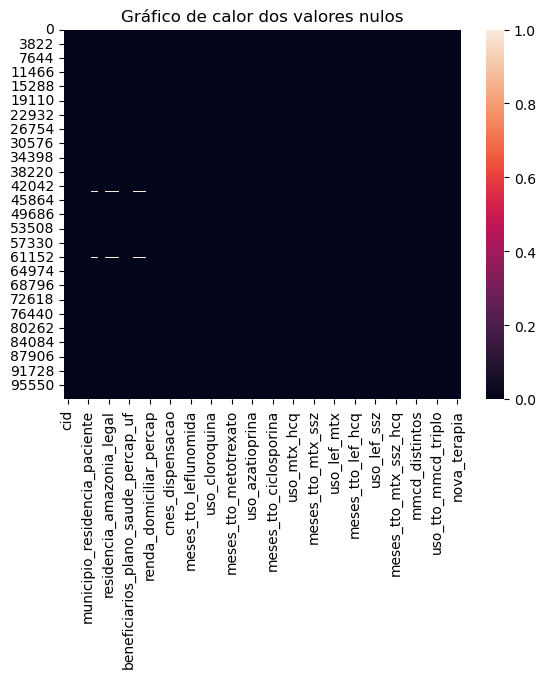

In [378]:
# Mapa de calor com valores nulos
sns.heatmap(df.isnull())
ax = plt.gca()
ax.set_title('Gráfico de calor dos valores nulos')
plt.show()

Para imputar os valores nulos foi utilizado o algoritmo `KNN Imputer` baseado no `k-Nearest Neighbors`. A atualização dos dados ausentes ocorreu no pipeline de treinamento, visando diminuir o viés do estudo.

## Avaliação dos dados
As colunas do dataframe foram avaliadas para identificar possíveis valores incorretos ou outliers.
### Variável dependente (nova_terapia)
Verificou-se que os dados encontram-se desbalanceados, onde os pacientes que não migraram de tratamento correspondem a 86,86% dos registros. Dessa forma, na etapa de predição serão testadas as técnicas de subamostragem e sobreamostragem para verificar se os scores dos algoritmos melhoram ou não com o balanceamento da classe.

In [379]:
# Função para contar os registros distintos e porcentagem de cada
def count_percent(coluna):
    print(coluna)
    # Obter os valores distintos e a contagem
    valores_distintos = df[coluna].value_counts()

    # Calcular a porcentagem de cada valor
    porcentagem = round(valores_distintos / len(df) * 100, 2)

    # Criar um novo dataframe com as informações obtidas
    df_count = pd.DataFrame({'Registros': valores_distintos, 'Porcentagem': porcentagem})

    # Exibir as contagens e porcentagens
    print(df_count)

count_percent('nova_terapia')

nova_terapia
       Registros  Porcentagem
False      86126       86.690
True       13228       13.310


### CID-10
Foi verificado que todos os valores de CID-10 informados na coluna `cid` são válidos.

In [380]:
# Plotar a quantidade de registros por CID-10
df['cid'].value_counts()

M058    48645
M060    26882
M050    10225
M068     7045
M053     5141
M051      859
M052      557
Name: cid, dtype: int64

Adicionalmente, foi criado um gráfico de barras empilhadas contendo a estratificação de cada CID-10 pela classe do dataframe.

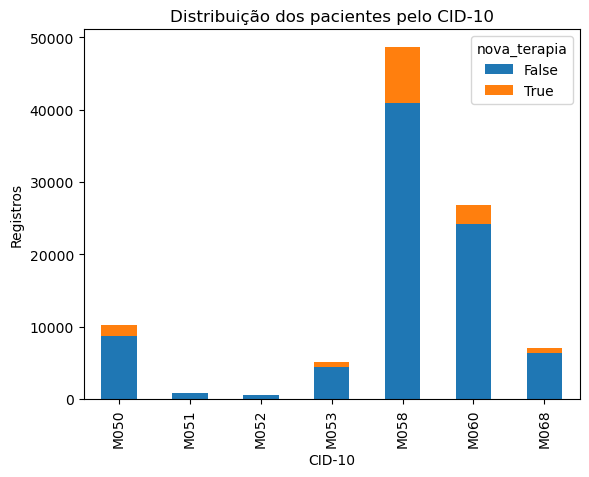

In [381]:
# Agrupar os dados pela coluna 'cid' e 'novo_tto' e contar os registros
cid_tto_count = df.groupby(['cid', 'nova_terapia']).size().reset_index(name='count')

# Transformar os dados em uma tabela pivô com as contagens por 'cid' e 'novo_tto'
cid_tto_pivot = pd.pivot_table(cid_tto_count, values='count', index='cid', columns='nova_terapia', fill_value=0)

# Criar um gráfico de barras empilhadas com as contagens de 'cid' e 'novo_tto'
fig, ax = plt.subplots()
cid_tto_pivot.plot(kind='bar', stacked=True, ax=ax)

# Exibir o gráfico
ax.set_title('Distribuição dos pacientes pelo CID-10')
ax.set_xlabel('CID-10')
ax.set_ylabel('Registros')
plt.show()

### Idade
Pode-se verificar que a variável referente a idade dos pacientes possui uma distribuição normal, a partir do histograma. Os dados observados estão de acordo com o Protocolo Clínico e Diretrizes Terapêuticas (PCDT) do Ministério da Saúde de Artrite Reumatóide, onde é frisado que "a AR é mais frequente em mulheres e na faixa etária de 30 a 50 anos, com pico de incidência na quinta década de vida".

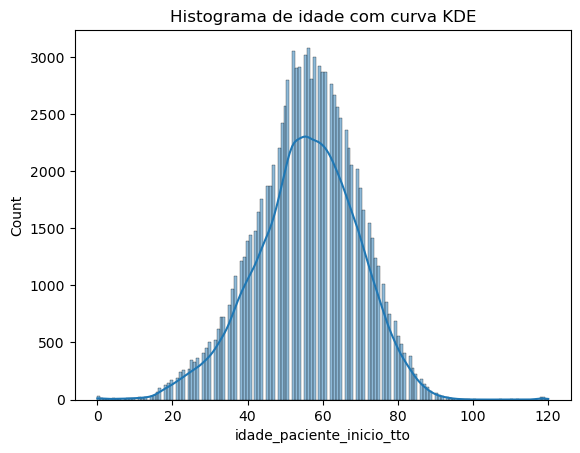

count   99354.000
mean       55.666
std        13.675
min         0.000
25%        47.000
50%        56.000
75%        65.000
max       120.000
Name: idade_paciente_inicio_tto, dtype: float64


In [382]:
# Criar o histograma com o KDE
sns.histplot(data=df, x='idade_paciente_inicio_tto', kde=True)

# Mostrar o gráfico
ax = plt.gca()
ax.set_title('Histograma de idade com curva KDE')
plt.show()

# Apresentar estatísticas sobre a coluna
print(df['idade_paciente_inicio_tto'].describe())

A idade mínima localizada foi de zero anos e por isso foi plotado o blox plot para verificar a ocorrência de outliers. Como o Ministério da Saúde possui um PCDT específico para Artrite Reumatóide Juvenil, os registros abaixo do primeiro quartil foram considerados outliers. Como a Artrite Reumatóide é uma doença crônica, os registros caracterizados como outliers acima do terceiro quartil não foram excluídos.   

Total de outliers inferiores:  694


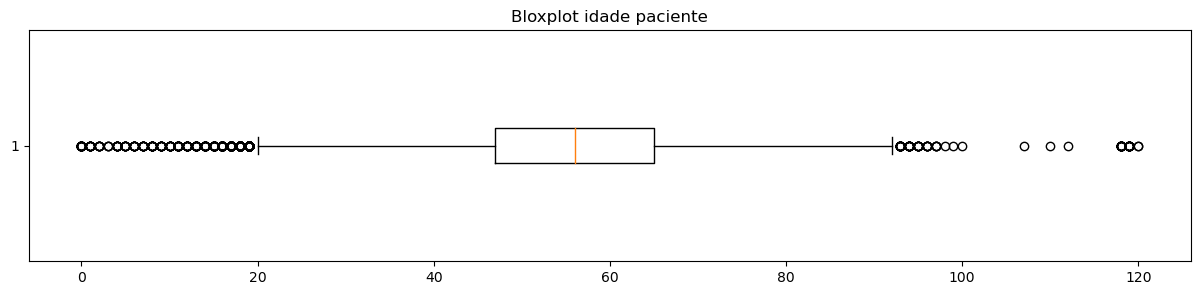

In [383]:
# Plotar boxplot
fig, ax = plt.subplots(figsize=(15,3))
ax.set_title('Bloxplot idade paciente')
ax.boxplot(df['idade_paciente_inicio_tto'], vert=False)

# Obter o intervalo interquartil
Q1 = df['idade_paciente_inicio_tto'].quantile(0.25)
Q3 = df['idade_paciente_inicio_tto'].quantile(0.75)
IQR = Q3 - Q1

# Definir o limite inferior de outlier
limite_inferior = Q1 - (1.5 * IQR)

# Contar a quantidade de outliers inferiores
count = df[df['idade_paciente_inicio_tto'] < limite_inferior]['idade_paciente_inicio_tto'].count()

# Mostrar a quantidade de outliers inferiores
print("Total de outliers inferiores: ", count) 

Paralelamente, foi realizada a avaliação de outliers por meio do algoritmo `KNN`, que combinou outras varáveis para a definição dos outliers. Como resultado, apenas 14 registros foram classificados como outliers.

In [384]:
# Instanciar o modelo KNN
preditor = KNN()

# Selecioanr a coluna de interesse
df_sel = df[['idade_paciente_inicio_tto']]

# Treinar o modelo
preditor.fit(df_sel)
outliers = preditor.labels_

# Contar os outliers
resultado = np.unique(outliers, return_counts=True)
print("Total de outliers KNN:", resultado[1][1])

Total de outliers KNN: 15


A última avaliação realizada foi levando em consideração a UF de atendimento do paciente, pois um determinado estado pode estar informando o SIA/SUS de forma incorreta ou possuir um atendimento diferenciado para a Artrite Reumatóide. Contudo, foi verificado que praticamente todas as UF atenderam pacientes com menos de 20 anos.

<Figure size 1500x800 with 0 Axes>

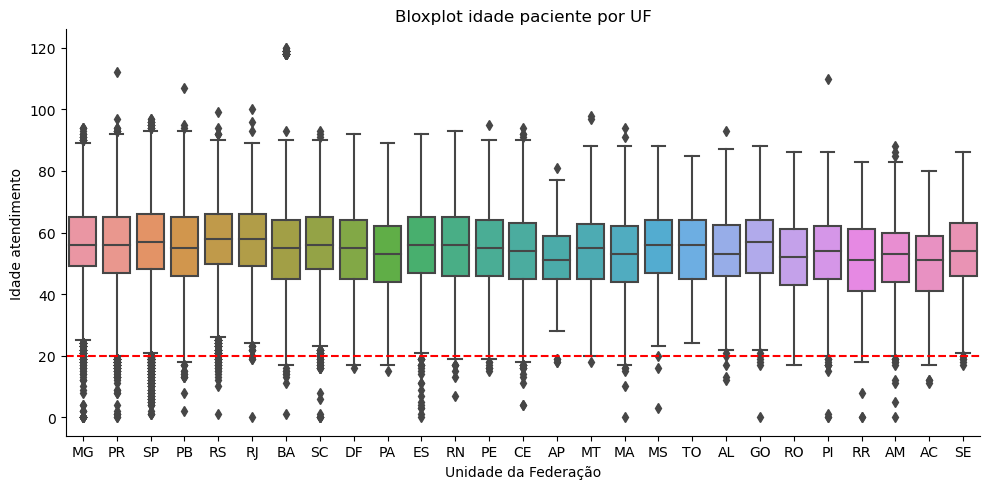

In [385]:
# Criar o boxplott
plt.figure(figsize=(15, 8))
sns.catplot(data=df, x='sigla_uf_dispensacao', y='idade_paciente_inicio_tto', kind='box', height=5, aspect=2)

# Plotar o gráfico
plt.axhline(y=20, linestyle='--', color='red')
plt.title("Bloxplot idade paciente por UF")
plt.xlabel('Unidade da Federação')
plt.ylabel('Idade atendimento')
plt.tight_layout()
plt.show()

Tendo em vista as características do atributo idade, principalmente ao fato do Ministério da Saúde possuir um PCDT de Artrite Reumatóide Juvenil, será levado em consideração a classificação de outlier obtida pelo bloxplot (diferença entre o primeiro e terceiro quartil multiplicado por 1,5).   
Esses registros foram excluídos do dataframe.

Registros antes da exclusão: 99354
Registros após a exclusão: 98660
Registros excluídos: 694


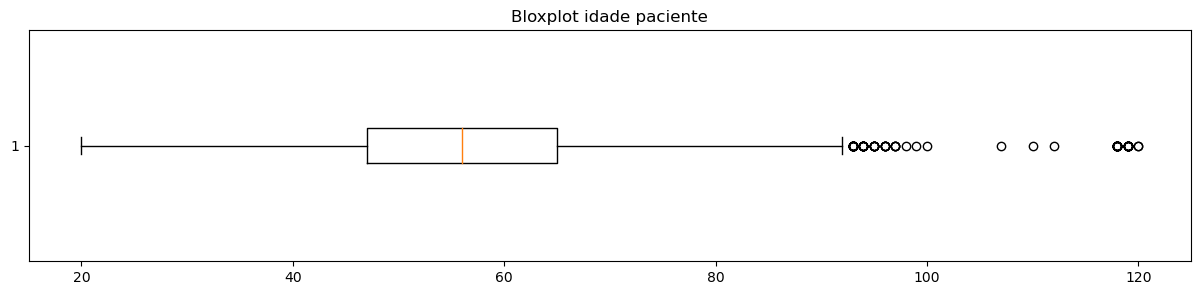

In [386]:
# Verificar a quantidade de registros antes da exclusão
qtd_registros_anterior = df.shape[0]

# Excluir do dataframe os registros considerados como outliers
df = df.loc[df['idade_paciente_inicio_tto'] >= limite_inferior]

# Plotar o boxplot atualizado
fig, ax = plt.subplots(figsize=(15,3))
ax.set_title('Bloxplot idade paciente')
ax.boxplot(df['idade_paciente_inicio_tto'], vert=False)

# Confirmar a exclusão
print(f'Registros antes da exclusão: {qtd_registros_anterior}')
print(f'Registros após a exclusão: {df.shape[0]}')
print(f'Registros excluídos: {qtd_registros_anterior - df.shape[0]}')

### Sexo
A coluna `sexo_paciente` possui todos os dados válidos, onde 84,85% dos pacientes são do sexo feminino. Os dados observados estão de acordo com o Protocolo Clínico e Diretrizes Terapêuticas (PCDT) do Ministério da Saúde de Artrite Reumatóide, conforme trecho abaixo:    
"A AR é mais frequente em mulheres e na faixa etária de 30 a 50 anos, com pico de incidência na quinta década de vida"

In [387]:
# Contar os registros distintos e porcentagem 
count_percent('sexo_paciente')

sexo_paciente
   Registros  Porcentagem
F      83716       84.850
M      14944       15.150


### Pirâmide etária

In [13]:
# Definir as faixas de idade
faixa_idade = range(0, 121, 5)

# Criar os grupos de faixas de idade
df['faixa_idade'] = pd.cut(df['idade_paciente_inicio_tto'], bins=faixa_idade)

# Calcular a contagem de pacientes por faixa de idade e sexo
df_contagem = df.groupby(['faixa_idade', 'sexo_paciente']).size().unstack()

# Criar um novo DataFrame
df_novo = pd.DataFrame({
    'faixa_idade': df_contagem.index.astype(str), 
    'count_feminino': df_contagem['F'],
    'count_masculino': df_contagem['M']
})

# Excluir a coluna adicionada no dataframe
df = df.drop(['faixa_idade'], axis=1)

# Multiplicar os valores da segunda coluna por -1
df_novo['count_masculino'] *= -1

# Instânciar a figura
fig = gp.Figure()
  
# Adicionar os dados dos sexos
fig.add_trace(gp.Bar(y= df_novo['faixa_idade'], x = df_novo['count_masculino'], name = 'Homens', orientation = 'h'))
fig.add_trace(gp.Bar(y = df_novo['faixa_idade'], x = df_novo['count_feminino'], name = 'Mulheres', orientation = 'h'))
  
# Plotar o gráfico
fig.update_layout(barmode = 'relative', bargap = 0.0, width=800, height=400, margin=dict(l=10, r=10, t=50, b=20), title={'text':'Pirâmide etária', 'x': 0.5}) 
fig.show()


### Município residência
Foi verificado que todos os registros da coluna `municipio_residencia_paciente` possuem valores do tipo numérico e com seis digítos, caracterizando que os valores são válidos com relação ao formato dos dados.

In [389]:
# Consultar informações do campo
df['municipio_residencia_paciente'].describe()

count    98660.000
mean    350872.562
std      73306.139
min     110001.000
25%     314810.000
50%     353930.000
75%     410760.000
max     530180.000
Name: municipio_residencia_paciente, dtype: float64

Contudo, foi verificado que o sistema SIA/SUS exportou os dados do Distrito Federal contendo mais de um município. 

In [390]:
# Listar os códigos IBGE distintos do DF
municipios_df = df[df['municipio_residencia_paciente'].astype(str).str.startswith('53')]['municipio_residencia_paciente'].unique()
for codigo_ibge in municipios_df:
    print(codigo_ibge)

530040
530180
530010
530140
530020
530060
530070
530130
530150
530090
530170
530050
530160


Para seguir o padrão do IBGE foi necessário transformar os códigos da coluna `municipio_residencia_paciente` que iniciam com `53` para `530010`.

In [18]:
# Substituir os codigos de municipios iniciados com 53 para 530010
df.loc[df['municipio_residencia_paciente'].astype(str).str.startswith('53'), 'municipio_residencia_paciente'] = 530010

# Confirmar a atualização
municipios_df = df[df['municipio_residencia_paciente'].astype(str).str.startswith('53')]['municipio_residencia_paciente'].unique()
for codigo_ibge in municipios_df:
    print(codigo_ibge)


530010


### População município residência
Anteriormente, foi verificado que a variável `populacao_residencia_paciente` possui valores nulos, sendo que os valores ausentes serão imputados no pipeline de treinamento dos modelos. Ao avaliar os dados não foram encontrados dados inconsistentes.

In [392]:
# Consultar informações do campo
df['populacao_residencia_paciente'].describe()

count      98087.000
mean     1639449.196
std      3641869.104
min          771.000
25%        36298.000
50%       158432.000
75%       723889.000
max     12396372.000
Name: populacao_residencia_paciente, dtype: float64

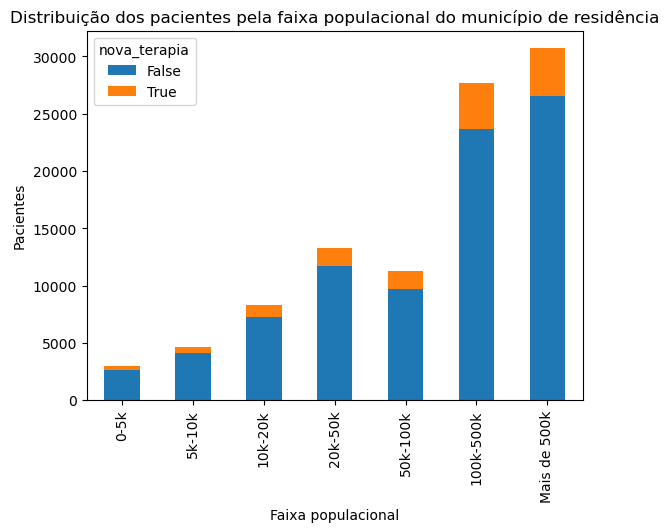

In [14]:
# Definir os limites dos grupos de população
limits = [0, 5000, 10000, 20000, 50000, 100000, 500000, float('inf')]

# Criar os rótulos do eixo X
labels = ['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k-100k', '100k-500k', 'Mais de 500k']

# Criar a coluna de grupos de população
df['populacao_grupo'] = pd.cut(df['populacao_residencia_paciente'], bins=limits, labels=labels, right=False)

# Agrupar os dados por 'populacao_grupo' e 'nova_terapia' e contar a quantidade de registros
grouped_data = df.groupby(['populacao_grupo', 'nova_terapia']).size().unstack()

# Excluir a coluna criada
df = df.drop(['populacao_grupo'], axis=1)

# Plotar o gráfico de barras empilhadas
grouped_data.plot.bar(stacked=True)
plt.title('Distribuição dos pacientes pela faixa populacional do município de residência')
plt.xlabel('Faixa populacional')
plt.ylabel('Pacientes')
plt.show()

### Região residência
A região de residência do paciente foi avaliada pela variável `regiao_residencia_paciente` e não foram localizados dados inconsistentes.

In [394]:
# Obter os valores distintos e a contagem
valores_distintos = df['regiao_residencia_paciente'].value_counts()

# Calcular a porcentagem de cada valor
porcentagem = round(valores_distintos / len(df) * 100, 2)

# Criar um novo dataframe com as informações obtidas
df_count = pd.DataFrame({'Registros': valores_distintos, 'Porcentagem': porcentagem})

# Exibir as contagens e porcentagens
print(df_count)

              Registros  Porcentagem
Sudeste           49761       50.440
Nordeste          31209       31.630
Norte              8826        8.950
Sul                4779        4.840
Centro-Oeste       4085        4.140


### Residência Amazônia legal e Semiárido
Anteriormente, foi verificado que as variáveis e `residencia_amazonia_legal` e `residencia_semiarido` possuem valores nulos, sendo que os valores ausentes serão imputados no pipeline de treinamento dos modelos. Ao avaliar os dados não foram encontrados dados inconsistentes.

In [395]:
# Contar os registros distintos e porcentagem 
count_percent('residencia_amazonia_legal')
count_percent('residencia_semiarido')

residencia_amazonia_legal
       Registros  Porcentagem
False      93706       94.980
True        4381        4.440
residencia_semiarido
       Registros  Porcentagem
False      90103       91.330
True        7984        8.090


### Estabelecimentos saúde e beneficiários de plano de saúde
Foi verificado que as variáveis `estabelecimentos_saude_percap_uf` e `beneficiarios_plano_saude_percap_uf` não possuem valor discrepante ou incorreto.

In [396]:
# Apresentar as informações do campo
print('Estabelecimentos de saúde per capita UF')
df['estabelecimentos_saude_percap_uf'].describe()

Estabelecimentos de saúde per capita UF


count   98660.000
mean        0.002
std         0.000
min         0.001
25%         0.001
50%         0.002
75%         0.002
max         0.007
Name: estabelecimentos_saude_percap_uf, dtype: float64

In [397]:
# Apresentar as informações do campo
print('Beneficiários de plano de saúde per capita UF')
df['beneficiarios_plano_saude_percap_uf'].describe()

Beneficiários de plano de saúde per capita UF


count   98660.000
mean        0.087
std         0.041
min         0.015
25%         0.058
50%         0.093
75%         0.108
max         0.232
Name: beneficiarios_plano_saude_percap_uf, dtype: float64

### IDHM, índice de Gini e renda per capita domiciliar
Anteriormente, foi verificado que as variáveis e `idhm_residencia_paciente` e `indice_gini` possuem valores nulos, sendo que os valores ausentes serão imputados no pipeline de treinamento dos modelos. A coluna `renda_domiciliar_percap` não possui valor nulo. Ao avaliar os dados não foram encontrados dados inconsistentes.

In [398]:
# Apresentar as informaçõe
print('IDHM')
df['idhm_residencia_paciente'].describe()

IDHM


count   98064.000
mean        0.746
std         0.060
min         0.453
25%         0.718
50%         0.757
75%         0.797
max         0.862
Name: idhm_residencia_paciente, dtype: float64

In [399]:
# Apresentar as informações do campo
print('Índice de Gini')
df['indice_gini'].describe()

Índice de Gini


count   98087.000
mean        0.540
std         0.045
min         0.424
25%         0.516
50%         0.562
75%         0.568
max         0.618
Name: indice_gini, dtype: float64

In [400]:
# Apresentar as informações do campo
print('Renda per capita UF')
df['renda_domiciliar_percap'].describe()

Renda per capita UF


count   98660.000
mean     1053.469
std       312.505
min       639.000
25%       872.000
50%       922.000
75%      1100.000
max      2480.000
Name: renda_domiciliar_percap, dtype: float64

### Município e UF dispensação
Foi verificado que as variáveis `codigo_municipio_dispensacao` e `sigla_uf_dispensacao` não possuem valor discrepante ou incorreto. Ao contrário da variável `municipio_residencia_paciente`, o DF não possui códigos IBGE inválidos na coluna `codigo_municipio_dispensacao`.

In [401]:
# Apresentar as informações do campo
print('Código município dispensação')
df['codigo_municipio_dispensacao'].describe()

Código município dispensação


count    98660.000
mean    351015.842
std      73238.527
min     110002.000
25%     315250.000
50%     354910.000
75%     410690.000
max     530010.000
Name: codigo_municipio_dispensacao, dtype: float64

In [402]:
# Apresentar as informações do campo
count_percent('sigla_uf_dispensacao')

sigla_uf_dispensacao
    Registros  Porcentagem
SP      35895       36.380
PR      16705       16.930
MG       9195        9.320
RS       6219        6.300
CE       3940        3.990
SC       3777        3.830
BA       3716        3.770
ES       2785        2.820
PB       2398        2.430
RJ       1886        1.910
PE       1734        1.760
DF       1715        1.740
PA       1099        1.110
MA        975        0.990
RN        905        0.920
PI        877        0.890
MS        840        0.850
GO        805        0.820
MT        725        0.730
AM        610        0.620
SE        588        0.600
AP        276        0.280
RO        257        0.260
AL        248        0.250
AC        206        0.210
TO        159        0.160
RR        125        0.130


### CNES solicitante e dispensador
Foi verificado que os dados da variável `cnes_dispensacao` não possuem problema. 

In [403]:
# Apresentar as informações do campo
print('Código município dispensação')
df['cnes_dispensacao'].describe()

Código município dispensação


count     98660.000
mean    3663146.823
std     1897172.260
min        3441.000
25%     2531496.000
50%     2784432.000
75%     4053400.000
max     9993827.000
Name: cnes_dispensacao, dtype: float64

In [404]:
# Apresentar as informações do campo
print('Código município dispensação')
df['cnes_solicitante'].describe()

Código município dispensação


count     98660.000
mean    1325431.149
std     2416237.582
min           0.000
25%           0.000
50%           0.000
75%     2315149.000
max     9997296.000
Name: cnes_solicitante, dtype: float64

Mais de dois terços dos registros da variável `cnes_solicitante` estão preenchidos com o valor zerado. Diante da grande quatidade de registros problemáticos a coluna `cnes_solicitante` foi excluída do dataframe.

In [15]:
# Contar os registros igual a 0 e distintos
contagem_zero = len(df[df['cnes_solicitante'] == 0])
contagem_total_distinto = len(df[df['cnes_solicitante'] != 0].drop_duplicates())

# Calcular a porcentagem
porcentagem_zero = contagem_zero / len(df) * 100
porcentagem_total_distinto = contagem_total_distinto / len(df) * 100

# Apresentar os valores
print(f"Registros igual a 0: {contagem_zero} ({round(porcentagem_zero,2)}%)")
print(f"Registros diferente de 0: {contagem_total_distinto} ({round(porcentagem_total_distinto,2)}%)")


Registros igual a 0: 68147 (68.59%)
Registros diferente de 0: 31095 (31.3%)


In [16]:
# Verificar a quantidade de colunas antes da exclusão
qtd_col_anterior = df.shape[1]

# Excluir as colunas
df = df.drop(['cnes_solicitante'], axis=1)

# Confirmar a exclusão
print(f'Colunas antes da exclusão: {qtd_col_anterior}')
print(f'Colunas após a exclusão: {df.shape[1]}')
print(f'Colunas excluídas: {qtd_col_anterior - df.shape[1]}')

Colunas antes da exclusão: 58
Colunas após a exclusão: 57
Colunas excluídas: 1


### Variáveis booleanas de tratamento
As variáveis booleanas que indicam se um paciente realizou determinado tratamento foram avaliadas para identificar se possuem algum valor diferente de `True` ou `False`, onde não foram encontrados registros com problemas.

In [407]:
# Contar os registros distintos e porcentagem 
count_percent('uso_leflunomida')
count_percent('uso_hidroxicloroquina')
count_percent('uso_cloroquina')
count_percent('uso_metotrexato')
count_percent('uso_sulfassalazina')
count_percent('uso_azatioprina')
count_percent('uso_ciclosporina')
count_percent('uso_ciclofosfamida')
count_percent('uso_mtx_hcq')
count_percent('uso_mtx_ssz')
count_percent('uso_ssz_hcq')
count_percent('uso_lef_mtx')
count_percent('uso_lef_hcq')
count_percent('uso_naproxeno')
count_percent('uso_lef_ssz')
count_percent('uso_mtx_ssz_hcq')

uso_leflunomida
       Registros  Porcentagem
True       58227       59.020
False      40433       40.980
uso_hidroxicloroquina
       Registros  Porcentagem
False      68215       69.140
True       30445       30.860
uso_cloroquina
       Registros  Porcentagem
False      98416       99.750
True         244        0.250
uso_metotrexato
       Registros  Porcentagem
True       50427       51.110
False      48233       48.890
uso_sulfassalazina
       Registros  Porcentagem
False      94419       95.700
True        4241        4.300
uso_azatioprina
       Registros  Porcentagem
False      96798       98.110
True        1862        1.890
uso_ciclosporina
       Registros  Porcentagem
False      98463       99.800
True         197        0.200
uso_ciclofosfamida
       Registros  Porcentagem
False      98660      100.000
uso_mtx_hcq
       Registros  Porcentagem
False      86597       87.770
True       12063       12.230
uso_mtx_ssz
       Registros  Porcentagem
False      97373       98.

Adicionalmente, foi plotado um gráfico de barras empilhadas para visualização da porcentagem de adoção de cada terapia.

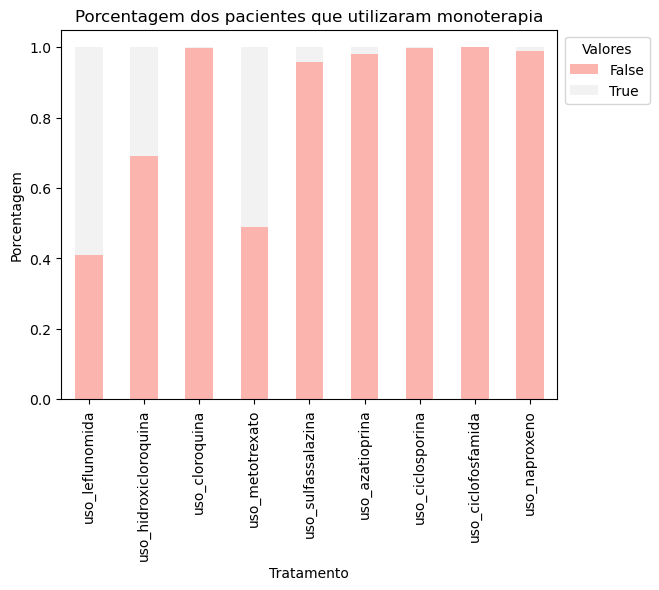

In [408]:
# Contar os valores
colunas = ['uso_leflunomida', 'uso_hidroxicloroquina', 'uso_cloroquina', 'uso_metotrexato', 'uso_sulfassalazina', 'uso_azatioprina', 'uso_ciclosporina', 'uso_ciclofosfamida', 'uso_naproxeno']
contagens = df[colunas].apply(lambda x: x.value_counts(normalize=True)).T

# Plotar o gráfico
contagens.plot.bar(stacked=True, colormap='Pastel1')
plt.title('Porcentagem dos pacientes que utilizaram monoterapia')
plt.xlabel('Tratamento')
plt.ylabel('Porcentagem')
plt.legend(title='Valores', loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

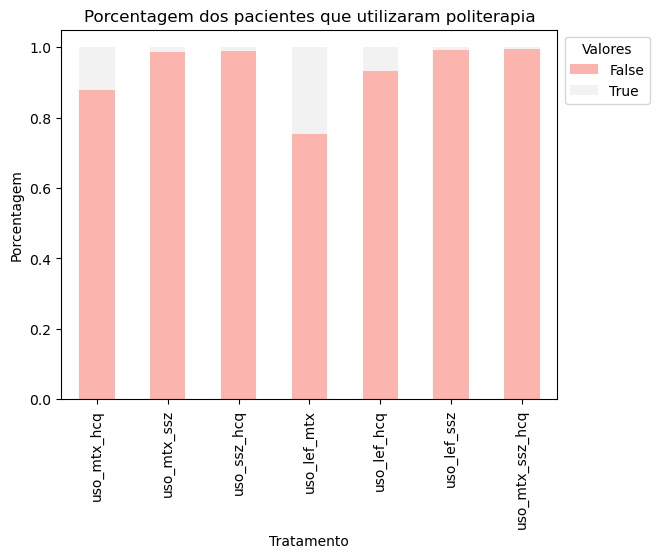

In [409]:
# Contar os valores
colunas = ['uso_mtx_hcq', 'uso_mtx_ssz', 'uso_ssz_hcq', 'uso_lef_mtx', 'uso_lef_hcq', 'uso_lef_ssz', 'uso_mtx_ssz_hcq']
contagens = df[colunas].apply(lambda x: x.value_counts(normalize=True)).T

# Plotar o gráfico
contagens.plot.bar(stacked=True, colormap='Pastel1')
plt.title('Porcentagem dos pacientes que utilizaram politerapia')
plt.xlabel('Tratamento')
plt.ylabel('Porcentagem')
plt.legend(title='Valores', loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Variáveis numéricas de tratamento
Foi verificado se cada coluna do dataset que informa o tempo de tratamento é do tipo inteiro, se possui algum número negativo ou maior que 62, ou se todos os seus registros estão com valores zerados.

In [410]:
# Função que verifica se a variável possui algum problema
def verificar_coluna_meses(coluna):
    c = 0

    if df[coluna].dtype != np.int64:
        c += 1
        print(f"A coluna '{coluna}' não é do tipo inteiro.")
        
    if (df[coluna] < 0).any():
        c += 1
        print(f"A coluna '{coluna}' contém números negativos.")
        
    if (df[coluna] > 63).any():
        c += 1
        print(f"A coluna '{coluna}' contém valores acima de 62.")

    if all(df[coluna] == 0):
        c += 1
        print(f"A coluna '{coluna}' possui todos os seus registros com valores zerados.")
        
    if c == 0:
        print(f"A coluna '{coluna}' não possui dados inconsistentes.")

verificar_coluna_meses('meses_tto_leflunomida')
verificar_coluna_meses('meses_tto_hidroxicloroquina')
verificar_coluna_meses('meses_tto_cloroquina')
verificar_coluna_meses('meses_tto_metotrexato')
verificar_coluna_meses('meses_tto_sulfassalazina')
verificar_coluna_meses('meses_tto_azatioprina')
verificar_coluna_meses('meses_tto_ciclosporina')
verificar_coluna_meses('meses_tto_ciclofosfamida')
verificar_coluna_meses('meses_tto_mtx_hcq')
verificar_coluna_meses('meses_tto_mtx_ssz')
verificar_coluna_meses('meses_tto_ssz_hcq')
verificar_coluna_meses('meses_tto_lef_mtx')
verificar_coluna_meses('meses_tto_lef_hcq')
verificar_coluna_meses('meses_tto_naproxeno')
verificar_coluna_meses('meses_tto_lef_ssz')
verificar_coluna_meses('meses_tto_mtx_ssz_hcq')
verificar_coluna_meses('meses_mmcd')
verificar_coluna_meses('maior_gap_mmcd')
verificar_coluna_meses('meses_tto_mmcd_duplo')
verificar_coluna_meses('meses_tto_mmcd_triplo')
verificar_coluna_meses('meses_total_tto')

A coluna 'meses_tto_leflunomida' não possui dados inconsistentes.
A coluna 'meses_tto_hidroxicloroquina' não possui dados inconsistentes.
A coluna 'meses_tto_cloroquina' não possui dados inconsistentes.
A coluna 'meses_tto_metotrexato' não possui dados inconsistentes.
A coluna 'meses_tto_sulfassalazina' não possui dados inconsistentes.
A coluna 'meses_tto_azatioprina' não possui dados inconsistentes.
A coluna 'meses_tto_ciclosporina' não possui dados inconsistentes.
A coluna 'meses_tto_ciclofosfamida' possui todos os seus registros com valores zerados.
A coluna 'meses_tto_mtx_hcq' não possui dados inconsistentes.
A coluna 'meses_tto_mtx_ssz' não possui dados inconsistentes.
A coluna 'meses_tto_ssz_hcq' não possui dados inconsistentes.
A coluna 'meses_tto_lef_mtx' não possui dados inconsistentes.
A coluna 'meses_tto_lef_hcq' não possui dados inconsistentes.
A coluna 'meses_tto_naproxeno' não possui dados inconsistentes.
A coluna 'meses_tto_lef_ssz' não possui dados inconsistentes.
A col

Foi verificado que a coluna `meses_tto_ciclofosfamida` possui todos os valores zerados. Dessa forma, a mesma será excluída do dataframe por não agregar informação ao conjunto de dados.

Por fim, foi plotado um gráfico para visualizar os dados.

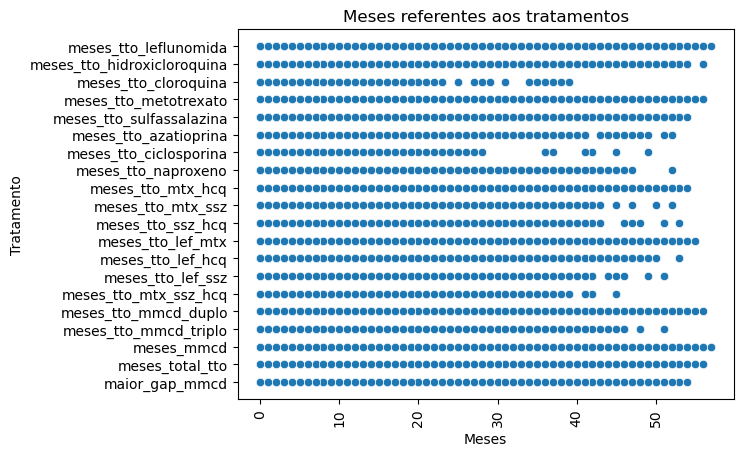

In [411]:
# Colunas para o gráfico de dispersão
colunas = ['meses_tto_leflunomida', 'meses_tto_hidroxicloroquina', 'meses_tto_cloroquina', 'meses_tto_metotrexato', 'meses_tto_sulfassalazina', 
           'meses_tto_azatioprina', 'meses_tto_ciclosporina', 'meses_tto_naproxeno', 'meses_tto_mtx_hcq', 'meses_tto_mtx_ssz', 'meses_tto_ssz_hcq',
           'meses_tto_lef_mtx', 'meses_tto_lef_hcq', 'meses_tto_lef_ssz', 'meses_tto_mtx_ssz_hcq', 'meses_tto_mmcd_duplo', 'meses_tto_mmcd_triplo',
           'meses_mmcd', 'meses_total_tto', 'maior_gap_mmcd']

# Transformar os dados
df_subconjunto = df[colunas]
df_melted = df_subconjunto.melt(var_name='Colunas', value_name='Valores')

# Plotar o gráfico
sns.scatterplot(data=df_melted, x='Valores', y='Colunas')
plt.xticks(rotation=90)
plt.title("Meses referentes aos tratamentos")
plt.xlabel('Meses')
plt.ylabel('Tratamento')
plt.show()

### MMCD distintos
Por último, restou avaliar a qualidade do dado referente a quantidade de MMCD distintos utilizados pelos pacientes, por meio da variável `mmcd_distintos`. Não foram encontrados dados inconsistentes.

In [412]:
# Verificar as informações da coluna
df['mmcd_distintos'].describe()

count   98660.000
mean        1.455
std         0.627
min         0.000
25%         1.000
50%         1.000
75%         2.000
max         4.000
Name: mmcd_distintos, dtype: float64

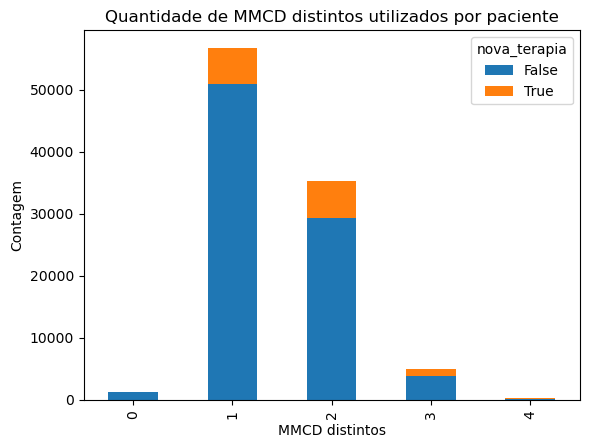

In [413]:
# Contar registros distintos por combinação de 'mmcd_distintos' e 'nova_terapia'
contagens = df.groupby(['mmcd_distintos', 'nova_terapia']).size().unstack()

# Criar o gráfico de barras empilhadas
contagens.plot(kind='bar', stacked=True)

# Plotar o gráfico
plt.title('Quantidade de MMCD distintos utilizados por paciente')
plt.xlabel('MMCD distintos')
plt.ylabel('Contagem')
plt.show()

## Transformar variáveis
### Variáveis categóricas nominais
As variáveis categóricas que não possuem ordem de grandeza entre os seus valores passarão pelo processo de One-Hot Enconding. Contudo, primeiramente foi verificado que aplicar a técnica para todas as colunas necessárias deixaria o dataframe com particamente 5 mil colunas. 

In [414]:
# Variáveis categóricas nominais
colunas_selecionadas = ['cid','sexo_paciente', 'municipio_residencia_paciente', 'regiao_residencia_paciente', 'sigla_uf_dispensacao', 'codigo_municipio_dispensacao', 'cnes_dispensacao']
valores_distintos = df[colunas_selecionadas].nunique()

# Exibir o resultado
print(valores_distintos)
print("Soma dos valores distintos:", valores_distintos.sum())

cid                                 7
sexo_paciente                       2
municipio_residencia_paciente    4451
regiao_residencia_paciente          5
sigla_uf_dispensacao               27
codigo_municipio_dispensacao      187
cnes_dispensacao                  215
dtype: int64
Soma dos valores distintos: 4894


Considerando as limitações do computador que irá rodar esse script, o One-Hot Enconding foi aplicado apenas para as colunas com menos de 50 valores distintos. A técnica será aplicada no pipeline de treinamento dos modelos.

### Variáveis categóricas ordinais
O dataframe não possui nenhuma variável categórica ordinal.
### Variáveis booleanas
As variáveis booleanas foram transformadas em 0 para os valores `false` e 1 para os valores `true`.

In [19]:
# Função para ransformar valores True em 1 e False em 0
transformacao = lambda x: 1 if x else 0

# Selecionar as colunas
colunas_booleanas = ['residencia_amazonia_legal', 'residencia_semiarido', 'uso_leflunomida', 'uso_hidroxicloroquina', 'uso_cloroquina', 'uso_metotrexato', 
    'uso_sulfassalazina', 'uso_azatioprina', 'uso_ciclosporina', 'uso_ciclofosfamida', 'uso_mtx_hcq','uso_mtx_ssz', 'uso_ssz_hcq', 'uso_lef_mtx', 
    'uso_lef_hcq', 'uso_naproxeno', 'uso_lef_ssz', 'uso_mtx_ssz_hcq', 'uso_tto_mmcd_duplo', 'uso_tto_mmcd_triplo', 'nova_terapia']

# Fazer a transformação
df[colunas_booleanas] = df[colunas_booleanas].applymap(transformacao)

# Confimar os dados alterados
df[colunas_booleanas]

,residencia_amazonia_legal,residencia_semiarido,uso_leflunomida,uso_hidroxicloroquina,uso_cloroquina,uso_metotrexato,uso_sulfassalazina,uso_azatioprina,uso_ciclosporina,uso_ciclofosfamida,uso_mtx_hcq,uso_mtx_ssz,uso_ssz_hcq,uso_lef_mtx,uso_lef_hcq,uso_naproxeno,uso_lef_ssz,uso_mtx_ssz_hcq,uso_tto_mmcd_duplo,uso_tto_mmcd_triplo,nova_terapia
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99349,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
99350,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99351,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99352,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### Escalonamento
Para o escalonamento das variveis numéricas foi utilizada técnica de padronização, utilizando a função `StandardScaler`. O escalonamento foi incluído no pipeline de treinamento dos modelos.
## Correlação
Foi verificado que em geral existe pouca correlação entre as variáveis de estudo.

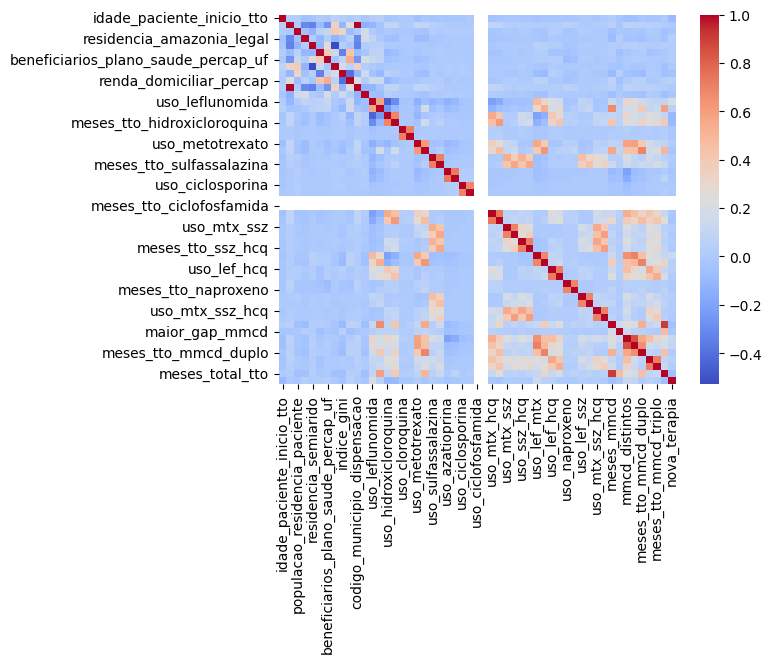

In [416]:
# Calcular a matriz de correlação
corr_matrix = df.corr()

# Gerar o mapa de calor
sns.heatmap(corr_matrix, cmap='coolwarm')

# Plotar o mapa de calor
plt.show()

As variáveis que possuem correlação acima de 0,7 foram listadas abaixo e avaliadas.

In [417]:
# Calcular a matriz de correlação
matriz_correlacao = df.corr()

# Localizar as colunas com correlação acima de 0,7
limite_correlacao = 0.7
colunas_correlacionadas = []
for coluna in matriz_correlacao:
    colunas_correlacionadas.extend([(coluna, coluna_correlacionada, matriz_correlacao[coluna][coluna_correlacionada])
                                   for coluna_correlacionada in matriz_correlacao.index
                                   if abs(matriz_correlacao[coluna][coluna_correlacionada]) > limite_correlacao
                                   and coluna != coluna_correlacionada])

# Exibir as colunas com correlação acima de 0,7
print(f'Colunas com correlação acima de 0,7:')
for coluna_correlacionada in colunas_correlacionadas:
    coluna_correlacionada_round = round(coluna_correlacionada[2], 3)
    print(f'{coluna_correlacionada[0]} x {coluna_correlacionada[1]}: {coluna_correlacionada_round}')


Colunas correlacionadas:
municipio_residencia_paciente x codigo_municipio_dispensacao: 0.998
codigo_municipio_dispensacao x municipio_residencia_paciente: 0.998
uso_cloroquina x meses_tto_cloroquina: 0.707
meses_tto_cloroquina x uso_cloroquina: 0.707
uso_sulfassalazina x meses_tto_sulfassalazina: 0.702
meses_tto_sulfassalazina x uso_sulfassalazina: 0.702
uso_azatioprina x meses_tto_azatioprina: 0.729
meses_tto_azatioprina x uso_azatioprina: 0.729
uso_mtx_hcq x meses_tto_mtx_hcq: 0.731
meses_tto_mtx_hcq x uso_mtx_hcq: 0.731
uso_ssz_hcq x meses_tto_ssz_hcq: 0.713
meses_tto_ssz_hcq x uso_ssz_hcq: 0.713
uso_lef_mtx x uso_tto_mmcd_duplo: 0.706
uso_lef_hcq x meses_tto_lef_hcq: 0.721
meses_tto_lef_hcq x uso_lef_hcq: 0.721
uso_mtx_ssz_hcq x meses_tto_mtx_ssz_hcq: 0.705
meses_tto_mtx_ssz_hcq x uso_mtx_ssz_hcq: 0.705
meses_mmcd x meses_total_tto: 0.91
mmcd_distintos x uso_tto_mmcd_duplo: 0.852
uso_tto_mmcd_duplo x uso_lef_mtx: 0.706
uso_tto_mmcd_duplo x mmcd_distintos: 0.852
uso_tto_mmcd_triplo 

A partir da avaliação realizada apenas a variável `codigo_municipio_dispensacao` foi excluída do modelo.

In [17]:
# Verificar a quantidade de colunas antes da exclusão
qtd_col_anterior = df.shape[1]

# Excluir as colunas
df = df.drop(['codigo_municipio_dispensacao'], axis=1)

# Confirmar a exclusão
print(f'Colunas antes da exclusão: {qtd_col_anterior}')
print(f'Colunas após a exclusão: {df.shape[1]}')
print(f'Colunas excluídas: {qtd_col_anterior - df.shape[1]}')

Colunas antes da exclusão: 57
Colunas após a exclusão: 56
Colunas excluídas: 1


### Reduzir dimensionalidade
Tendo em vista a correlação entre algumas variáveis do modelo, foi testado o quanto a redução da dimensionalidade do dataframe poderia interferir nos modelos. Para o teste utilizou-se o classificador `Naive Bayes` com o algoritmo de redução `PCA`. Para a realizar a comparação a métrica AUC ROC foi mensurada em treinamentos realizados com e sem a aplicação do PCA. Ao reduzir a dimensionalidade para 30 variáveis pode-se observar que os resultados tiveram pouca alteração e por isso o algoritmo PCA foi incluído no pipeline de treinamento dos modelos.

In [419]:
# Realizar o one-hot
colunas_selecionadas = ['cid','sexo_paciente', 'sigla_uf_dispensacao', 'regiao_residencia_paciente']
df_pca = pd.get_dummies(df, columns=colunas_selecionadas)

# Imputar valores nulos
df_pca = df_pca.fillna(df_pca.median())

# Separar variáveis independentes e dependente
X = df_pca.drop('nova_terapia', axis=1)
y = df_pca['nova_terapia']

# Escalonar os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1)

# Treinar e avaliar do Naive Bayes sem redução de dimensionalidade
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
auc_roc_original = roc_auc_score(y_test, y_pred)

# Reduzir a dimensionalidade com PCA
pca = PCA(n_components=30, random_state=1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Treinar e avaliar o Naive Bayes com redução de dimensionalidade
naive_bayes_pca = GaussianNB()
naive_bayes_pca.fit(X_train_pca, y_train)
y_pred_pca = naive_bayes_pca.predict(X_test_pca)
auc_roc_pca = roc_auc_score(y_test, y_pred_pca)

# Comparar os resultados
print(f"AUC ROC sem redução de dimensionalidade: {round(auc_roc_original,5)}")
print(f"AUC ROC com redução de dimensionalidade (PCA): {round(auc_roc_pca,5)}")


AUC ROC sem redução de dimensionalidade: 0.63321
AUC ROC com redução de dimensionalidade (PCA): 0.52843


## Balanceamento da classe
Devido ao baixo score obtido com o AUC ROC na etapa anterior, verificou-se que a classe do dataframe estava desbalanceda.

In [420]:
# Verificar os valores da classe
count_percent('nova_terapia')

nova_terapia
   Registros  Porcentagem
0      85516       86.680
1      13144       13.320


Foi observado que somente 13,3% dos pacientes haviam migrado para o tratamento diferente dos MMCD. Assim, foram testadas se as técnicas de sobreamostragem e subamostragem que podem aumentar o AUC ROC.
### Sobreamostragem

In [421]:
# Instanciar o balanceador
smote = SMOTE(sampling_strategy='minority', random_state=1)

# Realizar a sobreamostragem
X_over, y_over = smote.fit_resample(X_train, y_train)

# Treinar o modelo
nb_resampled = GaussianNB()
nb_resampled.fit(X_over, y_over)
y_pred_resampled = nb_resampled.predict(X_test)

# Plotar os resultados
auc_resampled = roc_auc_score(y_test, y_pred_resampled)
print("AUC ROC após sobreamostragem:", round(auc_resampled,5))

AUC ROC após sobreamostragem: 0.63272


### Subamostragem

In [422]:
# Instanciar o balanceador
tl = TomekLinks(sampling_strategy='majority')

# Realizar a sobreamostragem
X_under, y_under = tl.fit_resample(X_train, y_train)

# Treinar o modelo
nb_resampled = GaussianNB()
nb_resampled.fit(X_under, y_under)
y_pred_resampled = nb_resampled.predict(X_test)

# Plotar os resultados
auc_resampled = roc_auc_score(y_test, y_pred_resampled)
print("AUC ROC após subamostragem:", round(auc_resampled, 5))

AUC ROC após subamostragem: 0.63075


Foi verificado que o ganho com a técnica de subsmostragem foi minimo, e por isso foi aplicada a técnica de sobreamostragem no pipeline de treinamento.

## Dividir previsores e classe
O dataframe foi dividido em outros dois, sendo que um deles receberá as variáveis previsoras e outra receberá a classe.

In [20]:
# Dataframe com os previsores
X = df.drop("nova_terapia", axis=1)

# Dataframe com a classe
y = df[["nova_terapia"]].copy()

# Confirmar a criação dos dataframes
print(X.shape)
print(y.shape)

(99354, 55)
(99354, 1)


# Selecionar melhor modelo
## Pipeline
Foi criado um pipeline para realizar de forma aninhada as seguintes etapas:
- Transformar as variáveis categoricas nominais pelo One-hot encondig;
- Imputar valores nulos pelo cálculo da média;
- Padronizar as variáveis para que a diferença das escalas não afete o modelo;
- Reduzir a dimensionalidade do modelo;
- Aplicar a técnica de sobreamostragem para balancear a variável dependente;
- Criar o modelo a partir da seleção dos melhores paramêtros para cada algoritmo, utilizando o `GridSearchCV`;
- Realizar validação cruzada interna e externa (aninhada) para melhorar a generalização do modelo e reduir viés e a possíbilidade de overfiting;   
- Repetir todo o processo 3 vezes devido a característica estocástica do processo.   

In [47]:
# Quantidade de partes para validação cruzada
k_cv_interno = 10
k_cv_externo = 5

# Repetições da validação cruzada aninhada
repetir_processo = 3

# Definir as colunas que passarão pelo pré-processamento
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
colunas_categorias = ['cid','sexo_paciente', 'regiao_residencia_paciente', 'sigla_uf_dispensacao']

# Algoritmos para a transformação das colunas numéricas
transformacao_numerica = Pipeline(
    steps=[
        ("imputer", KNNImputer()), 
        ("scaler", StandardScaler())
])

# Algoritmos para a transformação das colunas categóricas
transformacao_categorias = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
])

# Consolidar as transformações
preprocessor = ColumnTransformer(
    transformers=[
        ("num", transformacao_numerica, colunas_numericas),
        ("cat", transformacao_categorias, colunas_categorias),
])

# Criar pipeline de treinamento
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("oversampler", SMOTE(random_state=1)),
        ("pca", PCA(n_components=30)),
        ("classifier", LogisticRegression())
])

## Regressão logística

In [425]:
# Hora início processo
horario_inicio = time.time()

# Adicionar o algoritmo ao pipeline
pipeline.steps[-1] = ("classifier", LogisticRegression(max_iter=1000, random_state=1))

# Hiperparâmetros para teste
parametros = {
    'classifier__tol':[0.0001, 0.00001],
    'classifier__C':[1.0, 2.0],
    'classifier__solver':['lbfgs', 'sag']
    }

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_regressao_linear = GridSearchCV(pipeline, parametros, scoring='roc_auc', cv=cv_interno, refit=True)#, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_regressao = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_regressao_linear, X, y.values.ravel(), cv=cv_externo, scoring='roc_auc', n_jobs=-1)

    auc_roc = np.mean(scores['test_score'])
    desvio_pad = np.std(scores['test_score'])
    resultado_regressao.append(auc_roc)

    horario_fim_loop = time.time()
    tempo_total_loop = horario_fim_loop - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"AUC ROC {i+1}: {round(auc_roc,5)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média AUC ROC: {round(np.mean(resultado_regressao),5)} ({round(np.std(resultado_regressao),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

AUC ROC 1: 0.72564 (0.004) 8s]
AUC ROC 2: 0.72586 (0.006) 29s]
AUC ROC 3: 0.7257 (0.004) 23s]
Média AUC ROC: 0.72573 (0.0)
Tempo total: 75m0s


## Naive Bayes
Como o Naive Bayes não possui parâmetros para o tunnig, para o treinamento desse algoritmo não será utilizado o `GridSearchCV` e a validação cruzada não será do tipo aninhada.

In [426]:
# Hora início processo
horario_inicio = time.time()

# Adicionar o algoritmo ao pipeline
pipeline.steps[-1] = ("classifier", GaussianNB())

# Variável para receber os dados de cada repetição da validação cruzada
resultado_nb = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)

    scores = cross_val_score(pipeline, X, y.values.ravel(), cv=cv, scoring='roc_auc', n_jobs=-1)

    resultado_nb.append(scores.mean())

    horario_fim_loop = time.time()
    tempo_total_loop = horario_fim_loop - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"AUC ROC {i+1}: {round(scores.mean(),5)} [{int(minutos_loop)}m{round(segundos_loop)}s]")

# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média AUC ROC: {round(np.mean(resultado_nb),5)} ({round(np.std(resultado_nb),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

AUC ROC 1: 0.678 40s]
AUC ROC 2: 0.67792 42s]
AUC ROC 3: 0.67806 41s]
Média AUC ROC: 0.67799 (0.0)
Tempo total: 2m3s


## KNN

In [22]:
# Hora início processo
horario_inicio = time.time()

# Adicionar o algoritmo ao pipeline
pipeline.steps[-1] = ("classifier", KNeighborsClassifier()) 

# Hiperparâmetros para teste
parametros = {
    'classifier__n_neighbors': [3, 5, 10], 
    'classifier__p': [1, 2]  
}

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_knn = GridSearchCV(pipeline, parametros, scoring='roc_auc', cv=cv_interno, refit=True, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_knn = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_knn, X, y.values.ravel(), cv=cv_externo, scoring='roc_auc', n_jobs=-1)
    
    auc_roc = np.mean(scores['test_score'])
    desvio_pad = np.std(scores['test_score'])
    resultado_knn.append(auc_roc)

    horario_fim_loop = time.time()
    tempo_total_loop = horario_fim_loop - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"AUC ROC {i+1}: {round(auc_roc,5)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média AUC ROC: {round(np.mean(resultado_knn),5)} ({round(np.std(resultado_knn),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

AUC ROC 1: 0.69909 (0.008) 54s]
AUC ROC 2: 0.70023 (0.005) 19s]
AUC ROC 3: 0.70109 (0.004) 2s]
Média AUC ROC: 0.70014 (0.001)
Tempo total: 162m15s


## Redes Neurais Artificiais

In [429]:
# Hora início processo
horario_inicio = time.time()

# Adicionar o algoritmo ao pipeline
pipeline.steps[-1] = ("classifier", MLPClassifier(max_iter=5000, random_state=1)) 

# Hiperparâmetros para teste
parametros = {
    'classifier__activation': ['relu', 'tanh'], 
    'classifier__solver': ['adam', 'sgd']
}

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_rna = GridSearchCV(pipeline, parametros, scoring='roc_auc', cv=cv_interno, refit=True, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_rna = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_rna, X, y.values.ravel(), cv=cv_externo, scoring='roc_auc', n_jobs=-1)
    
    auc_roc = np.mean(scores['test_score'])
    desvio_pad = np.std(scores['test_score'])
    resultado_rna.append(auc_roc)

    horario_fim_loop = time.time()
    tempo_total_loop = horario_fim_loop - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"AUC ROC {i+1}: {round(auc_roc,5)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média AUC ROC: {round(np.mean(resultado_rna),5)} ({round(np.std(resultado_rna),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC ROC 1: 0.74159 (0.004) 27s]


/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

AUC ROC 2: 0.73868 (0.007) 16s]


/Users/ricardoronsoni/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC ROC 3: 0.73973 (0.007) 30s]
Média AUC ROC: 0.74 (0.001)
Tempo total: 566m13s


# Selecionar hiperparâmetros
Já definido o melhor algoritmo, procedeu-se com a seleção dos melhores hiperparâmetros para as Redes Neurais Artificiais (RNA). O processo foi realizado utilizando validação cruzada (10 divisões) e repetido três vezes. O modelo foi criado a partir de uma divisão da base em treino (80%) e teste (20%). As seguintes alterações foram realizadas em relação ao treinamento anterior com as RNA:   
- Aumento do parâmetro `max_iter` para 5000;   
- Definição de duas camadas ocultas com 30 neurônios cada;   
- Adição do hiperparâmetro `alpha` para tunning do modelo.

In [67]:
# Adicionar o algoritmo ao pipeline
pipeline.steps[-1] = ("classifier", MLPClassifier(hidden_layer_sizes=(30,30), max_iter=5000, random_state=1)) 

# Hiperparâmetros para teste
parametros = {
    'classifier__activation': ['relu', 'tanh'], 
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001]
}

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = RepeatedKFold(n_splits=k_cv_interno, n_repeats=3, random_state=1)
grid_search = GridSearchCV(pipeline, parametros, scoring='roc_auc', cv=cv_interno, refit=True, n_jobs=-1)

# Verificar os melhores parâmetros
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=1)
gs_modelo = grid_search.fit(X_treino, y_treino.values.ravel())

# Salvar o modelo treinado
with open('modelo.pkl', 'wb') as file:
    pickle.dump(gs_modelo.best_estimator_, file)

# Consultar os melhores parâmetros
print(f"Melhores parâmetros: {gs_modelo.best_params_}")
print(f"Melhor AUC ROC: {round(gs_modelo.best_score_, 5)}")

Melhores parâmetros: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__solver': 'sgd'}
Melhor AUC ROC: 0.74243


# Predição e resultados
A predição foi realizada com o modelo criado com os melhores parâmetros do `GridSearchCV`. Após isso, foram apresentadas as seguites métricas de avaliação da predição:   
- Acurácia (Accuracy): É a proporção de registros corretamente classificados em relação ao total.   
- Precisão (Precision): Indica a proporção de registros classificados como positivos que são realmente positivos.   
- Sensibilidade (Recall): É a proporção de exemplos positivos que foram corretamente identificados.   
- F1-Score: É uma medida combinada da precisão e revocação, calculada como a média harmônica entre essas duas métricas.   
- Área sob a curva ROC (AUC-ROC): É uma métrica que avalia a capacidade discriminativa do modelo em diferentes limiares de classificação. Ela mede a capacidade de distinguir entre as classes positiva e negativa, independentemente do ponto de corte.   
- Curva de calibração: Informa a precisão com que a probabilidade predita corresponde à taxa de eventos observada em um conjunto de dados.

In [68]:
# Realizar a predição
y_previsto = gs_modelo.predict(X_teste)

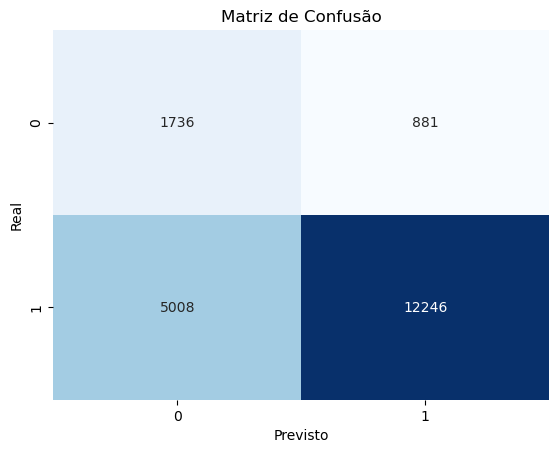

Acurácia: 0.704
Precisão: 0.933
Sensibilidade (Recall): 0.710
F1-Score: 0.806


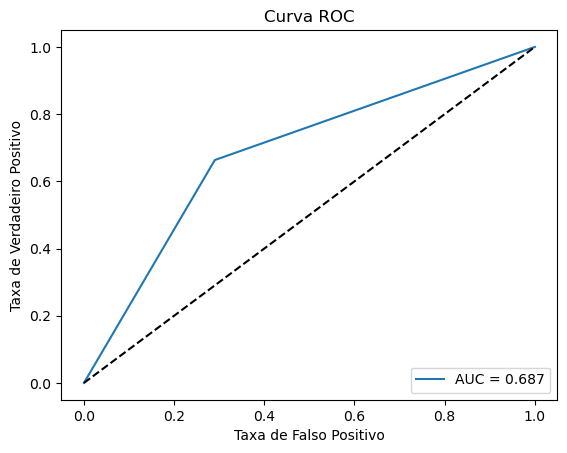

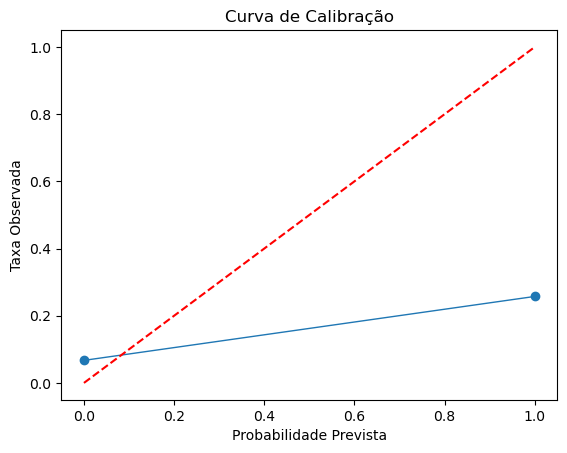

In [99]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_teste, y_previsto)

# Reorganizar a matriz de confusão para os valores da variável dependente
verdadeiros_positivos = cm[0, 0]
falsos_positivos = cm[1, 0]
falsos_negativos = cm[0, 1]
verdadeiros_negativos = cm[1, 1]
confusion_matrix = np.array([[verdadeiros_negativos, falsos_positivos], [falsos_negativos, verdadeiros_positivos]])

# Plotar a matriz de confusão
plt.figure()
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Calcular as métricas de avaliação
accuracy = np.diagonal(confusion_matrix).sum() / confusion_matrix.sum()
precision = verdadeiros_positivos / (falsos_positivos + verdadeiros_positivos)
recall = verdadeiros_positivos / (falsos_negativos + verdadeiros_positivos)
f1_score = 2 * (precision * recall) / (precision + recall)

# Apresentar os valores das métricas
print(f'Acurácia: {accuracy:.3f}')
print(f'Precisão: {precision:.3f}')
print(f'Sensibilidade (Recall): {recall:.3f}')
print(f'F1-Score: {f1_score:.3f}')

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_teste, y_previsto)
auc = roc_auc_score(y_teste, y_previsto)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calcular a curva
percentiles, observed_rates = calibration_curve(y_teste, y_previsto, n_bins=10)

# Plote a curva de calibração
plt.plot(observed_rates, percentiles, marker='o', linewidth=1)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Taxa Observada')
plt.title('Curva de Calibração')
plt.show()

Ao avaliar os resultados por classe, verificou-se que o algoritmo teve as seguintes taxas de acerto (acurácia):
- Classe 0 (não migrou de tratamento): 66,33%
- Classe 1 (migrou de tratamento): 70,97%